In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
from torchvision import transforms

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from collections import namedtuple

In [2]:
train_path = Path('../Data/cats_dogs_dataset/train/')
test_path = Path('../Data/cats_dogs_dataset/valid/')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df(train_path):
    files = filelist(train_path, '.txt')
    annotations = []
    for file in files:
        filedata = {}
        label, xmin, ymin, xmax, ymax = open(file, 'r').readline().split()
        filedata['filename'] = file.replace('.txt', '.jpg')
        filedata['class'] = label
        filedata['xmin'] = xmin
        filedata['ymin'] = ymin
        filedata['xmax'] = xmax
        filedata['ymax'] = ymax
        annotations.append(filedata)
    return pd.DataFrame(annotations)

In [4]:
df_test = generate_train_df(test_path)
print(df_test.shape)
df_test.head()

(400, 6)


,class,filename,xmax,xmin,ymax,ymin
0,1,..\Data\cats_dogs_dataset\valid\Abyssinian_116...,249,71,190,43
1,1,..\Data\cats_dogs_dataset\valid\Abyssinian_125...,393,215,176,23
2,1,..\Data\cats_dogs_dataset\valid\Abyssinian_128...,166,46,168,22
3,1,..\Data\cats_dogs_dataset\valid\Abyssinian_135...,257,20,278,58
4,1,..\Data\cats_dogs_dataset\valid\Abyssinian_137...,1017,593,549,108


In [5]:
#label encode target
class_dict = {'1': 0, '2': 1}
df_test['class'] = df_test['class'].apply(lambda x:  class_dict[x])

In [6]:
print(df_test.shape)
df_test.head()

(400, 6)


,class,filename,xmax,xmin,ymax,ymin
0,0,..\Data\cats_dogs_dataset\valid\Abyssinian_116...,249,71,190,43
1,0,..\Data\cats_dogs_dataset\valid\Abyssinian_125...,393,215,176,23
2,0,..\Data\cats_dogs_dataset\valid\Abyssinian_128...,166,46,168,22
3,0,..\Data\cats_dogs_dataset\valid\Abyssinian_135...,257,20,278,58
4,0,..\Data\cats_dogs_dataset\valid\Abyssinian_137...,1017,593,549,108


In [7]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[3],x[4],x[2]])

def resize_image_bb(read_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(read_path).replace('valid', 'resized')
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [8]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
for index, row in df_test.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_test['new_path'] = new_paths
df_test['new_bb'] = new_bbs

In [9]:
im = cv2.imread(df_test.values[0][1])
bb = create_bb_array(df_test.values[0])
print(im.shape)
print(bb)

(500, 333, 3)
['43' '71' '190' '249']


In [10]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 43.,  71., 189., 248.], dtype=float32)

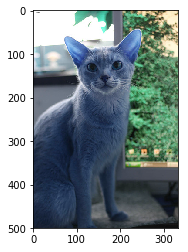

In [11]:
plt.imshow(im)

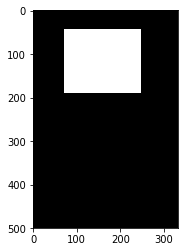

In [12]:
plt.imshow(Y, cmap='gray')

In [13]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))
    
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

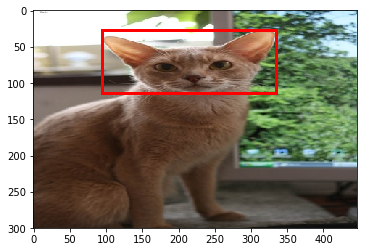

In [14]:
#original
im = cv2.imread(df_test.values[0][6])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_test.values[0][7])

In [15]:
df_test = df_test.reset_index()

In [16]:
X = df_test[['new_path', 'new_bb']]
Y = df_test['class']

In [17]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [18]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [19]:
model = BB_model().cuda()
model.load_state_dict(torch.load("new_bbmodel_40epochs.pt"))
model.eval()

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [20]:
df_test.head()

,index,class,filename,xmax,xmin,ymax,ymin,new_path,new_bb
0,0,0,..\Data\cats_dogs_dataset\valid\Abyssinian_116...,249,71,190,43,..\Data\cats_dogs_dataset\resized\Abyssinian_1...,"[26.0, 95.0, 113.0, 334.0]"
1,1,0,..\Data\cats_dogs_dataset\valid\Abyssinian_125...,393,215,176,23,..\Data\cats_dogs_dataset\resized\Abyssinian_1...,"[19.0, 192.0, 146.0, 351.0]"
2,2,0,..\Data\cats_dogs_dataset\valid\Abyssinian_128...,166,46,168,22,..\Data\cats_dogs_dataset\resized\Abyssinian_1...,"[17.0, 41.0, 134.0, 148.0]"
3,3,0,..\Data\cats_dogs_dataset\valid\Abyssinian_135...,257,20,278,58,..\Data\cats_dogs_dataset\resized\Abyssinian_1...,"[35.0, 26.0, 166.0, 345.0]"
4,4,0,..\Data\cats_dogs_dataset\valid\Abyssinian_137...,1017,593,549,108,..\Data\cats_dogs_dataset\resized\Abyssinian_1...,"[27.0, 166.0, 136.0, 283.0]"


In [21]:
Detection = namedtuple("Detection", ["image_path", "orig_bb", "pred_bb", "orig_class", "pred_class"])
examples = []
X = df_test[['new_path', 'new_bb', "class"]]
images_count = 100
for i in range(images_count):
    im_path = X.values[i][0]
    bb_value = X.values[i][1].astype(int)
    
    im = transforms.ToTensor()(read_image(im_path)).unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        out_class, out_bb = model(im.cuda())
    print(out_class)
    out_class = torch.argmax(out_class).item()
    print(out_class)
    bb_hat = out_bb.detach().cpu().numpy()
    bb_hat = bb_hat.astype(int)[0]
    sample_class = X.values[i][2]
    
    print("original bb:%21s\npredicted bb:%20s\noriginal class: %15s\npredicted: %20s\n" % (bb_value, bb_hat, sample_class, out_class))
    detection = Detection(im_path, bb_value, bb_hat, sample_class, out_class)
    examples.append(detection)

tensor([[ 1.6513, -1.7343]], device='cuda:0')
0
original bb:    [ 26  95 113 334]
predicted bb:   [ 26 237 164 361]
original class:               0
predicted:                    0

tensor([[ 2.7724, -2.8950]], device='cuda:0')
0
original bb:    [ 19 192 146 351]
predicted bb:   [ 21 247 131 344]
original class:               0
predicted:                    0

tensor([[ 1.4963, -1.6315]], device='cuda:0')
0
original bb:    [ 17  41 134 148]
predicted bb:   [ 52 207 186 334]
original class:               0
predicted:                    0

tensor([[ 1.5249, -1.8079]], device='cuda:0')
0
original bb:    [ 35  26 166 345]
predicted bb:   [ 47 268 196 388]
original class:               0
predicted:                    0

tensor([[ 2.0282, -2.2015]], device='cuda:0')
0
original bb:    [ 27 166 136 283]
predicted bb:   [ 34 249 168 361]
original class:               0
predicted:                    0

tensor([[ 1.1917, -1.2028]], device='cuda:0')
0
original bb:    [ 29 124 166 321]
predicted bb:

tensor([[ 1.4588, -1.7587]], device='cuda:0')
0
original bb:    [ 55 160 159 281]
predicted bb:   [ 54 301 212 413]
original class:               1
predicted:                    0

tensor([[-1.5238,  1.2869]], device='cuda:0')
1
original bb:    [ 51 140 114 247]
predicted bb:   [ 46 187 139 309]
original class:               1
predicted:                    1

tensor([[ 1.0761, -1.2666]], device='cuda:0')
0
original bb:    [ 91 271 176 364]
predicted bb:   [ 54 256 217 408]
original class:               1
predicted:                    0

tensor([[-0.8884,  0.5831]], device='cuda:0')
1
original bb:    [109 187 207 323]
predicted bb:   [ 46 201 170 317]
original class:               1
predicted:                    1

tensor([[-2.6891,  2.3351]], device='cuda:0')
1
original bb:    [122 189 197 305]
predicted bb:   [ 68 201 160 260]
original class:               1
predicted:                    1

tensor([[ 1.5885, -1.7095]], device='cuda:0')
0
original bb:    [ 23  96 171 234]
predicted bb:

In [22]:
# loop over the example detections
total_iou = 0.0
total_acc = 0

for detection in examples:
    # load the image
    # image = cv2.imread(detection.image_path)
    #     image = cv2.cvtColor(cv2.imread(detection.image_path), cv2.COLOR_BGR2RGB)
    # draw the ground-truth bounding box along with the predicted
    # bounding box
    #     cv2.rectangle(image, (detection.orig_bb[3], detection.orig_bb[2]), (detection.orig_bb[1], detection.orig_bb[0]), (0, 255, 0), 2)
    #     cv2.rectangle(image, (detection.pred_bb[3], detection.pred_bb[2]), (detection.pred_bb[1], detection.pred_bb[0]), (0, 0, 255), 2)
    # compute the intersection over union and display it
    iou = bb_intersection_over_union(detection.orig_bb, detection.pred_bb)
    total_iou = total_iou + iou
    if detection.orig_class == detection.pred_class:
        total_acc = total_acc + 1
    #     cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    print("{}: {:.4f}".format(detection.image_path, iou))
    # show the output image
    #     cv2.imshow("Image", image)
    #     cv2.waitKey(0)

print("Average iou : {}, total accuracy: {}".format((total_iou / images_count), (total_acc/images_count)))

..\Data\cats_dogs_dataset\resized\Abyssinian_116.jpg: 0.2887
..\Data\cats_dogs_dataset\resized\Abyssinian_125.jpg: 0.5312
..\Data\cats_dogs_dataset\resized\Abyssinian_128.jpg: 0.0000
..\Data\cats_dogs_dataset\resized\Abyssinian_135.jpg: 0.1834
..\Data\cats_dogs_dataset\resized\Abyssinian_137.jpg: 0.1464
..\Data\cats_dogs_dataset\resized\Abyssinian_154.jpg: 0.3381
..\Data\cats_dogs_dataset\resized\Abyssinian_174.jpg: 0.0523
..\Data\cats_dogs_dataset\resized\Abyssinian_191.jpg: 0.4156
..\Data\cats_dogs_dataset\resized\american_bulldog_103.jpg: 0.3059
..\Data\cats_dogs_dataset\resized\american_bulldog_11.jpg: 0.4437
..\Data\cats_dogs_dataset\resized\american_bulldog_13.jpg: 0.0563
..\Data\cats_dogs_dataset\resized\american_bulldog_130.jpg: 0.2514
..\Data\cats_dogs_dataset\resized\american_bulldog_134.jpg: 0.7749
..\Data\cats_dogs_dataset\resized\american_bulldog_140.jpg: 0.2747
..\Data\cats_dogs_dataset\resized\american_bulldog_149.jpg: 0.5576
..\Data\cats_dogs_dataset\resized\american_bu

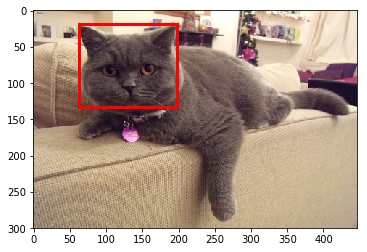

In [23]:
# loop over the example detections
total_iou = 0.0

im = cv2.imread(detection.image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, detection.orig_bb)


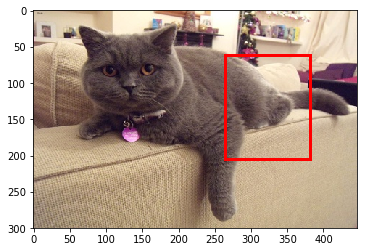

In [24]:
im_path = detection.image_path
bb_value = detection.pred_bb
im = transforms.ToTensor()(read_image(im_path)).unsqueeze_(0)
out_class, out_bb = model(im.cuda())
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)[0]
im = cv2.imread(detection.image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, bb_hat)